Data shape: (729, 6)
        time  open  high   low  close    volume
0 2023-01-17  0.50  0.50  0.49   0.49  17063512
1 2023-01-18  0.49  0.53  0.49   0.51  69799999
2 2023-01-19  0.51  0.51  0.49   0.49  22488547
3 2023-01-20  0.50  0.51  0.49   0.50   6123431
4 2023-01-23  0.52  0.54  0.51   0.51  63887312
Features calculated. Shape: (729, 33)

Pattern Distribution:
pattern_label
0    644
1     43
2     42
Name: count, dtype: int64

Accumulation: 43
Distribution: 42

Training set: (544, 13)
Test set: (136, 13)

=== Training Random Forest ===
Random Forest Accuracy: 0.8676

Classification Report:
              precision    recall  f1-score   support

  No Pattern       0.89      0.97      0.93       119
Accumulation       0.33      0.11      0.17         9
Distribution       0.50      0.12      0.20         8

    accuracy                           0.87       136
   macro avg       0.57      0.40      0.43       136
weighted avg       0.83      0.87      0.83       136


=== Training X

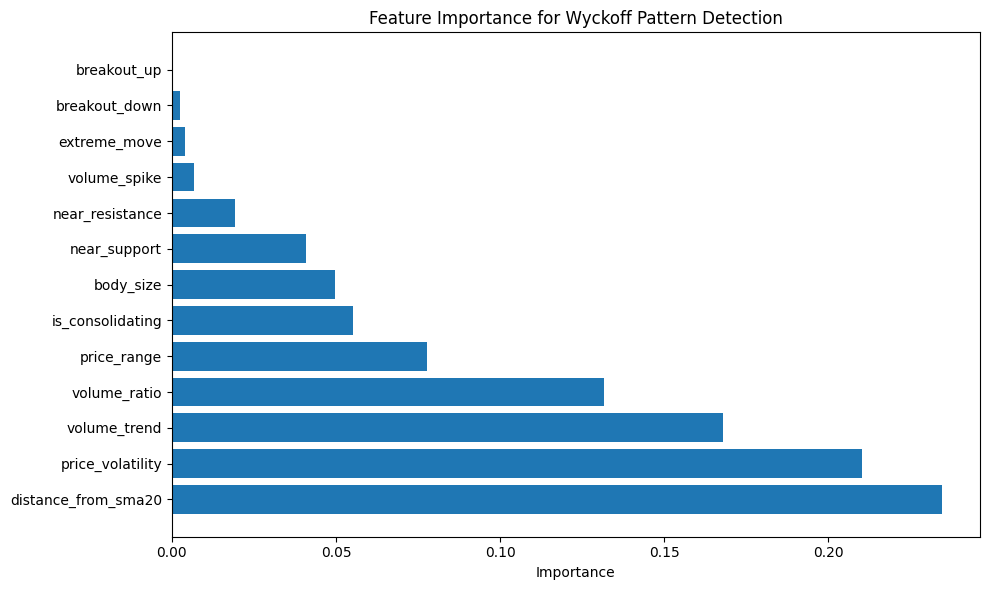


Top 5 Most Important Features:
                feature  importance
4   distance_from_sma20    0.234454
5      price_volatility    0.210219
12         volume_trend    0.167882
2          volume_ratio    0.131642
0           price_range    0.077589

=== Latest Pattern Detection ===
Detected Pattern: No Pattern
Confidence: 98.67%

Probabilities:
  No Pattern: 98.67%
  Accumulation: 0.87%
  Distribution: 0.47%


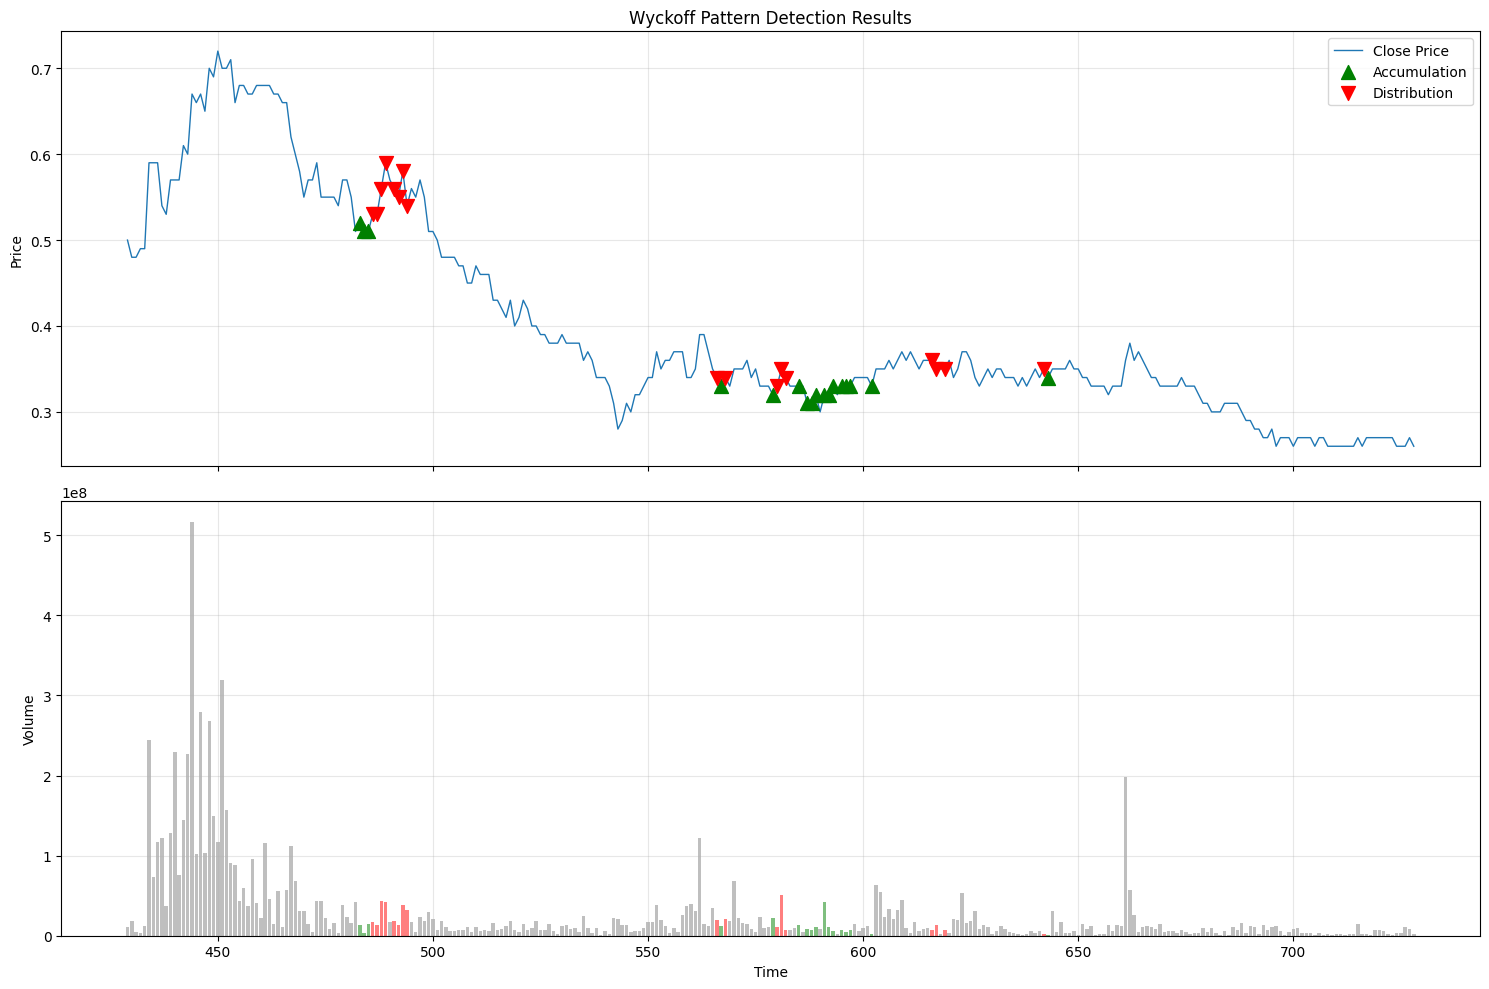


✅ Models saved successfully!
Files created:
  - wyckoff_rf_model.pkl
  - wyckoff_scaler.pkl
  - wyckoff_features.pkl


In [7]:
# ========================================
# Wyckoff Pattern Detection with ML
# Complete Pipeline for Python Notebook
# ========================================

# %% [markdown]
# ## 1. Import Libraries

import pandas as pd
import numpy as np
from cassandra.cluster import Cluster
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ML Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb

# Technical Analysis
from scipy.signal import find_peaks, argrelextrema
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

# %% [markdown]
# ## 2. Connect to Cassandra & Load Data

def load_data_from_cassandra(symbol='BTC', limit=10000):
    """ดึงข้อมูล candlestick จาก Cassandra"""
    cluster = Cluster(['127.0.0.1'])
    session = cluster.connect()
    session.set_keyspace('data_stock')
    
    query = f"""
        SELECT time, open, high, low, close, volume 
        FROM candlestick_data 
        WHERE symbol = '{symbol}'
        LIMIT {limit}
    """
    
    rows = session.execute(query)
    df = pd.DataFrame(list(rows))
    
    # แปลง time เป็น datetime และเรียงลำดับ
    df['time'] = pd.to_datetime(df['time'])
    df = df.sort_values('time').reset_index(drop=True)
    
    cluster.shutdown()
    return df

# โหลดข้อมูล
df = load_data_from_cassandra(symbol='BTC', limit=5000)
print(f"Data shape: {df.shape}")
print(df.head())

# %% [markdown]
# ## 3. Feature Engineering for Wyckoff Patterns

def calculate_technical_features(df, window=20):
    """คำนวณ features สำหรับ Wyckoff detection"""
    df = df.copy()
    
    # === Price-based Features ===
    # 1. Price Range & Volatility
    df['price_range'] = df['high'] - df['low']
    df['body_size'] = abs(df['close'] - df['open'])
    df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)
    df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']
    
    # 2. Moving Averages
    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['ema_20'] = df['close'].ewm(span=20).mean()
    
    # 3. Price Position
    df['distance_from_sma20'] = (df['close'] - df['sma_20']) / df['sma_20'] * 100
    df['price_volatility'] = df['close'].rolling(window=window).std()
    
    # 4. Support/Resistance Detection
    df['local_min'] = df['low'].rolling(window=window, center=True).min() == df['low']
    df['local_max'] = df['high'].rolling(window=window, center=True).max() == df['high']
    
    # === Volume-based Features ===
    # 5. Volume Analysis
    df['volume_ma'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_ma']
    df['volume_trend'] = df['volume'].rolling(window=10).apply(lambda x: linregress(range(len(x)), x)[0])
    
    # 6. Volume Spikes (Climax Detection)
    volume_std = df['volume'].rolling(window=20).std()
    df['volume_spike'] = (df['volume'] > df['volume_ma'] + 2*volume_std).astype(int)
    
    # === Wyckoff-specific Features ===
    # 7. Range-bound Detection (Consolidation)
    df['price_std'] = df['close'].rolling(window=window).std()
    df['is_consolidating'] = (df['price_std'] < df['price_std'].rolling(window=50).mean() * 0.7).astype(int)
    
    # 8. Spring/UTAD Detection (extreme moves that reverse)
    df['price_change'] = df['close'].pct_change()
    df['extreme_move'] = (abs(df['price_change']) > df['price_change'].rolling(window=20).std() * 2).astype(int)
    
    # 9. Tests (price returning to support/resistance)
    df['near_support'] = (df['low'] <= df['low'].rolling(window=window).min() * 1.02).astype(int)
    df['near_resistance'] = (df['high'] >= df['high'].rolling(window=window).max() * 0.98).astype(int)
    
    # 10. Trend Detection
    df['higher_high'] = df['high'] > df['high'].shift(1)
    df['higher_low'] = df['low'] > df['low'].shift(1)
    df['lower_high'] = df['high'] < df['high'].shift(1)
    df['lower_low'] = df['low'] < df['low'].shift(1)
    
    # 11. Phase Transition Indicators
    df['breakout_up'] = ((df['close'] > df['high'].rolling(window=window).max().shift(1)) & 
                         (df['volume'] > df['volume_ma'] * 1.5)).astype(int)
    df['breakout_down'] = ((df['close'] < df['low'].rolling(window=window).min().shift(1)) & 
                           (df['volume'] > df['volume_ma'] * 1.5)).astype(int)
    
    return df

# คำนวณ features
df_features = calculate_technical_features(df)
print(f"Features calculated. Shape: {df_features.shape}")

# %% [markdown]
# ## 4. Label Creation (Manual or Semi-Automated)

def detect_accumulation_distribution(df, lookforward=20, threshold=0.05):
    """
    สร้าง labels โดยอัตโนมัติ
    0 = No Pattern, 1 = Accumulation, 2 = Distribution
    
    Accumulation: consolidation ตามด้วยขาขึ้น
    Distribution: consolidation ตามด้วยขาลง
    """
    labels = []
    
    for i in range(len(df) - lookforward):
        # ดูว่าช่วงนี้เป็น consolidation ไหม
        current_range = df.iloc[i:i+10]
        is_consolidating = current_range['is_consolidating'].mean() > 0.6
        
        if is_consolidating:
            # ดูว่าหลังจากนี้ราคาไปทางไหน
            future_prices = df.iloc[i+10:i+lookforward]['close']
            current_price = df.iloc[i]['close']
            
            price_change = (future_prices.max() - current_price) / current_price
            price_drop = (current_price - future_prices.min()) / current_price
            
            # Accumulation: ราคาขึ้นมากกว่า threshold
            if price_change > threshold and price_change > price_drop:
                labels.append(1)  # Accumulation
            # Distribution: ราคาลงมากกว่า threshold
            elif price_drop > threshold and price_drop > price_change:
                labels.append(2)  # Distribution
            else:
                labels.append(0)  # No clear pattern
        else:
            labels.append(0)  # Not consolidating
    
    # เติม labels ที่เหลือ
    labels.extend([0] * lookforward)
    
    return labels

# สร้าง labels
df_features['pattern_label'] = detect_accumulation_distribution(df_features)

# ดู distribution ของ labels
print("\nPattern Distribution:")
print(df_features['pattern_label'].value_counts())
print(f"\nAccumulation: {(df_features['pattern_label']==1).sum()}")
print(f"Distribution: {(df_features['pattern_label']==2).sum()}")

# %% [markdown]
# ## 5. Prepare Training Data

# เลือก features ที่จะใช้
feature_columns = [
    'price_range', 'body_size', 'volume_ratio', 'volume_spike',
    'distance_from_sma20', 'price_volatility', 'is_consolidating',
    'extreme_move', 'near_support', 'near_resistance',
    'breakout_up', 'breakout_down', 'volume_trend'
]

# ลบ NaN
df_clean = df_features.dropna()

X = df_clean[feature_columns]
y = df_clean['pattern_label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# %% [markdown]
# ## 6. Train ML Models

# === Random Forest ===
print("\n=== Training Random Forest ===")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)

print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, 
                          target_names=['No Pattern', 'Accumulation', 'Distribution']))

# === XGBoost ===
print("\n=== Training XGBoost ===")
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)

print(f"XGBoost Accuracy: {accuracy_score(y_test, xgb_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred,
                          target_names=['No Pattern', 'Accumulation', 'Distribution']))

# %% [markdown]
# ## 7. Feature Importance Analysis

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance for Wyckoff Pattern Detection')
plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# %% [markdown]
# ## 8. Real-time Pattern Detection Function

def detect_wyckoff_pattern(df_latest, model, scaler, feature_columns, window=50):
    """
    ใช้โมเดลที่ train แล้วเพื่อ detect pattern ใน real-time
    
    Parameters:
    - df_latest: DataFrame ของข้อมูลล่าสุด
    - model: trained ML model
    - scaler: fitted StandardScaler
    - feature_columns: list of feature names
    - window: จำนวนแท่งเทียนที่ต้องการวิเคราะห์
    """
    # คำนวณ features
    df_with_features = calculate_technical_features(df_latest.tail(window))
    
    # เอาแถวล่าสุด
    latest_features = df_with_features[feature_columns].iloc[-1:].fillna(0)
    
    # Scale และ predict
    latest_scaled = scaler.transform(latest_features)
    prediction = model.predict(latest_scaled)[0]
    probability = model.predict_proba(latest_scaled)[0]
    
    pattern_names = {0: 'No Pattern', 1: 'Accumulation', 2: 'Distribution'}
    
    result = {
        'pattern': pattern_names[prediction],
        'confidence': probability[prediction] * 100,
        'probabilities': {
            'No Pattern': probability[0] * 100,
            'Accumulation': probability[1] * 100,
            'Distribution': probability[2] * 100
        },
        'timestamp': df_latest.iloc[-1]['time']
    }
    
    return result

# ทดสอบการ detect
latest_detection = detect_wyckoff_pattern(
    df_features, 
    rf_model, 
    scaler, 
    feature_columns
)

print("\n=== Latest Pattern Detection ===")
print(f"Detected Pattern: {latest_detection['pattern']}")
print(f"Confidence: {latest_detection['confidence']:.2f}%")
print(f"\nProbabilities:")
for pattern, prob in latest_detection['probabilities'].items():
    print(f"  {pattern}: {prob:.2f}%")

# %% [markdown]
# ## 9. Visualization of Detected Patterns

def plot_detected_patterns(df, predictions, n_samples=200):
    """แสดงกราฟพร้อม detected patterns"""
    df_plot = df.tail(n_samples).copy()
    df_plot['prediction'] = predictions[-n_samples:]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    
    # Plot price
    ax1.plot(df_plot.index, df_plot['close'], label='Close Price', linewidth=1)
    
    # Highlight patterns
    acc_mask = df_plot['prediction'] == 1
    dist_mask = df_plot['prediction'] == 2
    
    ax1.scatter(df_plot[acc_mask].index, df_plot[acc_mask]['close'], 
               color='green', marker='^', s=100, label='Accumulation', zorder=5)
    ax1.scatter(df_plot[dist_mask].index, df_plot[dist_mask]['close'], 
               color='red', marker='v', s=100, label='Distribution', zorder=5)
    
    ax1.legend()
    ax1.set_ylabel('Price')
    ax1.set_title('Wyckoff Pattern Detection Results')
    ax1.grid(True, alpha=0.3)
    
    # Plot volume
    colors = ['green' if p == 1 else 'red' if p == 2 else 'gray' 
             for p in df_plot['prediction']]
    ax2.bar(df_plot.index, df_plot['volume'], color=colors, alpha=0.5)
    ax2.set_ylabel('Volume')
    ax2.set_xlabel('Time')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# สร้าง predictions สำหรับ dataset ทั้งหมด
all_predictions = rf_model.predict(scaler.transform(df_clean[feature_columns]))
plot_detected_patterns(df_clean, all_predictions, n_samples=300)

# %% [markdown]
# ## 10. Save Model for Production

import joblib

# บันทึกโมเดล
joblib.dump(rf_model, 'wyckoff_rf_model.pkl')
joblib.dump(scaler, 'wyckoff_scaler.pkl')
joblib.dump(feature_columns, 'wyckoff_features.pkl')

print("\n✅ Models saved successfully!")
print("Files created:")
print("  - wyckoff_rf_model.pkl")
print("  - wyckoff_scaler.pkl")
print("  - wyckoff_features.pkl")

# %% [markdown]
# ## 11. Load Model for Real-time Usage

def load_wyckoff_detector():
    """โหลดโมเดลที่ save ไว้"""
    model = joblib.load('wyckoff_rf_model.pkl')
    scaler = joblib.load('wyckoff_scaler.pkl')
    features = joblib.load('wyckoff_features.pkl')
    return model, scaler, features

# Example usage:
# model, scaler, features = load_wyckoff_detector()
# new_data = load_data_from_cassandra(symbol='AAPL', limit=100)
# result = detect_wyckoff_pattern(new_data, model, scaler, features)